<hr style="height:2px;">

# Apply trained CARE model for for denoising of *X-ray Holographic Nanotomography* data

Adapted from demo notebook. 

This notebook demonstrates applying a CARE model for a 3D denoising task, assuming that training was already completed via [2_training.ipynb](2_training.ipynb).  
The trained model is assumed to be located in the folder `models` with the name `my_model`.

More documentation is available at http://csbdeep.bioimagecomputing.com/doc/.

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file, plot_some
from csbdeep.io import save_tiff_imagej_compatible
from csbdeep.models import CARE

2021-07-16 17:41:03.670386: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# SET DATA PATH
datapath = "/home/jrho/XNH/JanXrayData/CARE/mCTX/"

<hr style="height:2px;">

# Raw low-SNR image and associated high-SNR ground truth

Plot the test stack pair and define its image axes, which will be needed later for CARE prediction.

image size = (256, 512, 512)
image axes = ZYX


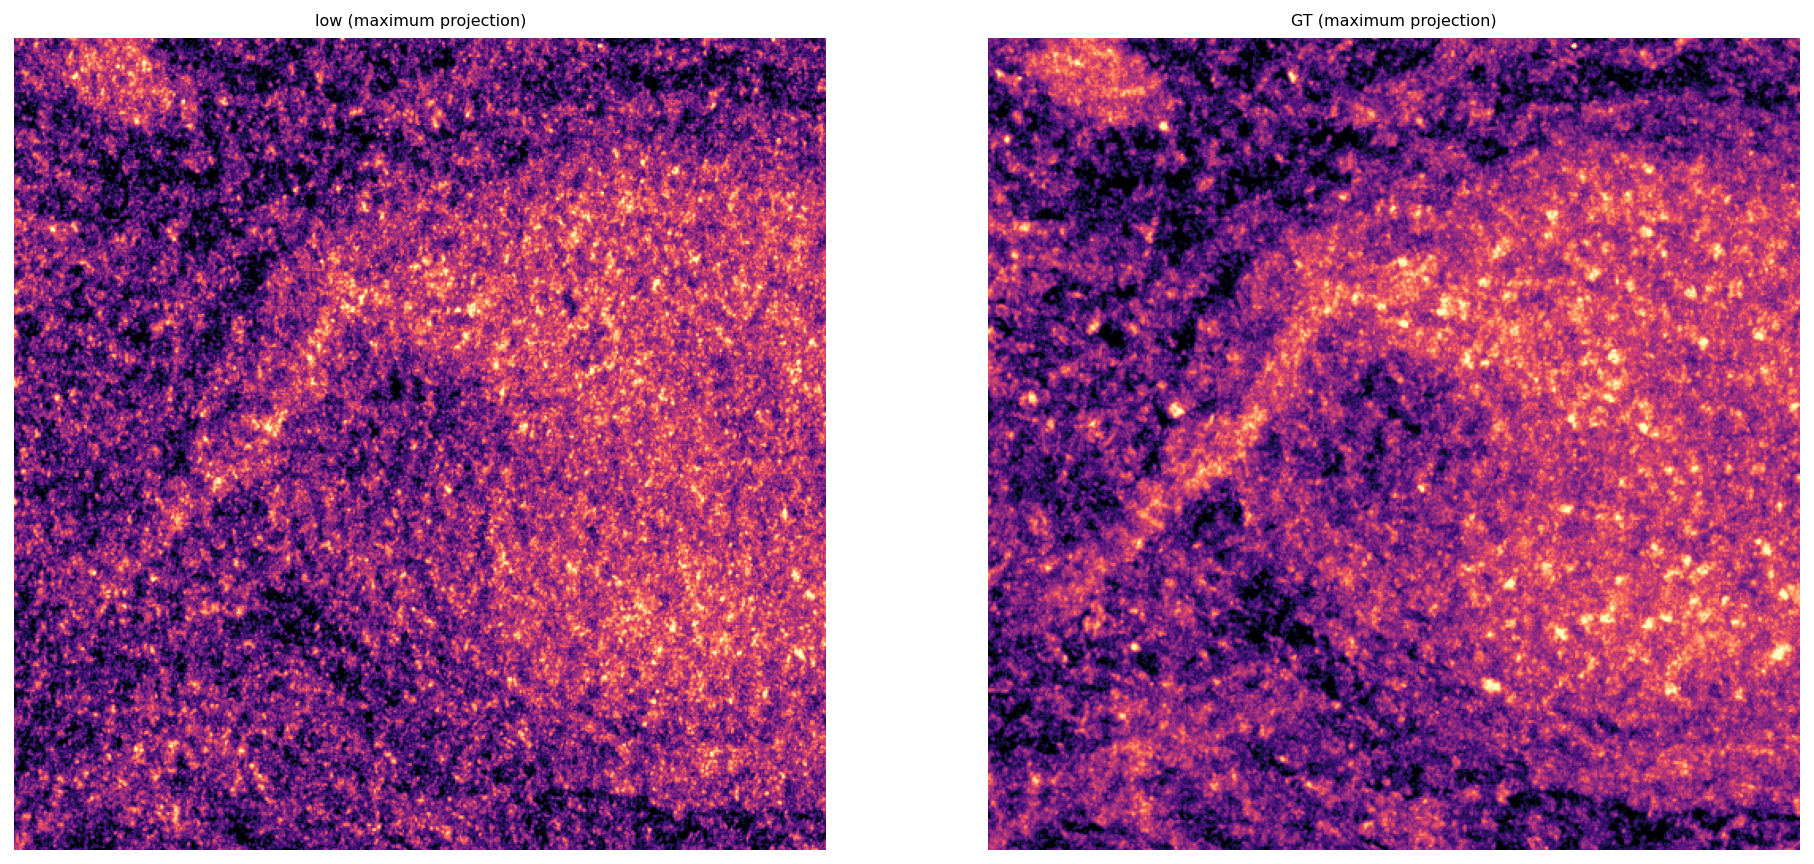

In [4]:
y = imread(datapath + 'test/GT/mCTX_17keV_30nm_512c_first256.tif')
x = imread(datapath + 'test/low/mCTX_17keV_30nm_512c_first256.tif')

axes = 'ZYX'
print('image size =', x.shape)
print('image axes =', axes)

plt.figure(figsize=(16,10))
plot_some(np.stack([x,y]),
          title_list=[['low (maximum projection)','GT (maximum projection)']], 
          pmin=2,pmax=99.8);

<hr style="height:2px;">

# CARE model

Load trained model (located in base directory `models` with name `my_model`) from disk.  
The configuration was saved during training and is automatically loaded when `CARE` is initialized with `config=None`.

In [ ]:
model = CARE(config=None, name='my_model', basedir='models')

## Apply CARE network to raw image

Predict the restored image (image will be successively split into smaller tiles if there are memory issues).

In [ ]:
%%time
restored = model.predict(x, axes)

Alternatively, one can directly set `n_tiles` to avoid the time overhead from multiple retries in case of memory issues.

**Note**: *Out of memory* problems during `model.predict` can also indicate that the GPU is used by another process. In particular, shut down the training notebook before running the prediction (you may need to restart this notebook).

In [ ]:
%%time
restored = model.predict(x, axes, n_tiles=(1,4,4))

## Save restored image

Save the restored image stack as a ImageJ-compatible TIFF image, i.e. the image can be opened in ImageJ/Fiji with correct axes semantics.

In [ ]:
Path('results').mkdir(exist_ok=True)
save_tiff_imagej_compatible('results/%s_nGFP_0.1_0.2_0.5_20_14_late.tif' % model.name, restored, axes)

<hr style="height:2px;">

# Raw low/high-SNR image and denoised image via CARE network

Plot the test stack pair and the predicted restored stack (middle).

In [ ]:
plt.figure(figsize=(16,10))
plot_some(np.stack([x,restored,y]),
          title_list=[['low (maximum projection)','CARE (maximum projection)','GT (maximum projection)']], 
          pmin=2,pmax=99.8);